<a href="https://colab.research.google.com/github/Traintain/2022-1-BI-Proyecto1-G4/blob/main/Proyecto_1_Grupo_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Inteligencia de negocios 2022-1**

**Proyecto 1 - Eligibilidad de un paciente para ensayos clínicos**

Juan Manuel Rivera López - 201534131

Juan Sebastián Arévalo - 201728738

Juan David Villamil – 201812268


# 0.Importacion de librerías

In [ ]:
!pip install contractions --quiet
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

True

In [ ]:
#Manejo de datos
import pandas as pd
import numpy as np
import string

#Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re, string, unicodedata
import contractions
from contractions import contractions_dict
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

#Entrenamiento del modelo
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator,TransformerMixin

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

from sklearn import tree

from tqdm import tqdm
import tensorflow as tf

# Importar/ Exportar modelos
from joblib import dump, load

In [ ]:
data_raw=pd.read_csv('clinical_trials_on_cancer_data_clasificacion.csv', sep=',', encoding = 'utf-8',index_col=None)

# 1.Entendimiento del negocio

Las intervenciones como ensayos clínicos en pacientes con cancer suelen ser muy restrictivos, ya que se excluye a pacientes con comorbilidades, tratamientos concomitantes o un límite de edad.

Para mejorar el proceso de selección de pacientes se realizó un clasificador binario, de forma que pueda predecir, a partir de un párrafo corto, si un paciente es candidato o no a ser parte de un ensayo clínico

# 2.Entendimiento de los datos
Autor: Juan Manuel Rivera

Daremos una revisión a la calidad de los datos

In [ ]:
# Revisamos cuántos registros tenemos
data_raw.shape

(12000, 2)

In [ ]:
# Luego vemos a grandes rasgos cada columna, para ver el tipo de dato que tiene
data_raw.head()

,label,study_and_condition
0,__label__0,study interventions are Saracatinib . recurren...
1,__label__1,study interventions are Stem cell transplantat...
2,__label__0,study interventions are Lenograstim . recurren...
3,__label__0,study interventions are Doxorubicin . stage ii...
4,__label__1,study interventions are Poly I-C . prostate ca...


A partir del diccionario sabemos que hay dos columnas

- **label:** indica si el paciente es elegible (0) o no elegible (1) para los ensayos clínicos
- **study_and_condition:** indica información sobre el estudio y sobre el tipo de cáncer del paciente. Estos datos están separados por un punto

Teniendo esto en cuenta convertiremos los valores de label a valor numérico y separaremos los valores de study y condition en dos columnas aparte

In [ ]:
def cleanAndSeparate(data):
  
  # Seleccionamos el último valor de la columna label. Con esto sabremos si es clase 0 o 1
  data['label'] = pd.to_numeric(data['label'].apply(lambda x: x[-1]))
  

  # Copiamos las columnas a separar en un dataframe independiente
  temp=data['study_and_condition'].str.split('.',expand=True,n=1)

  # Unimos los datos de los estudios, eliminando el encabezado
  data['study'] = temp[0].apply(lambda x: x[24:])
  data['condition']=temp[1]
  data.drop(labels='study_and_condition',axis=1,inplace=True)
  
  return data

In [ ]:
data=data_raw.copy()
data=cleanAndSeparate(data)
data

,label,study,condition
0,0,Saracatinib,recurrent verrucous carcinoma of the larynx d...
1,1,Stem cell transplantation,hodgkin lymphoma diagnosis and history of con...
2,0,Lenograstim,recurrent adult diffuse mixed cell lymphoma d...
3,0,Doxorubicin,stage iii diffuse large cell lymphoma diagnos...
4,1,Poly I-C,prostate cancer diagnosis and unresolved irae...
...,...,...,...
11995,0,Prednisolone hemisuccinate,recurrent childhood large cell lymphoma diagn...
11996,0,Bevacizumab,recurrent rectal cancer diagnosis and absolut...
11997,1,"Antibodies, Monoclonal",recurrent lymphoblastic lymphoma diagnosis an...
11998,0,Vorinostat,colorectal cancer diagnosis and patients must...


## Calidad de los datos

### Validez

Cada columna tiene el tipo de dato que le corresponde según el diccionario. Revisaremos cada columna en caso de que haya alguno no válido

In [ ]:
data.dtypes

label         int64
study        object
condition    object
dtype: object

In [ ]:
columnas = data.columns
for name in columnas:
  print(name)
  print(data[name].unique())
  print()

label
[0 1]

study
['Saracatinib ' 'Stem cell transplantation ' 'Lenograstim ' ...
 'Estradiol 17 beta-cypionate ' 'Adalimumab '
 'PV-10 (rose bengal disodium, 10%) ']

condition
[' recurrent verrucous carcinoma of the larynx diagnosis and patients must agree to use adequate birth control for the duration of study participation and for at least eight weeks after discontinuation of study drug'
 ' hodgkin lymphoma diagnosis and history of congenital hematologic immunologic or metabolic disorder which in the estimation of the pi poses prohibitive risk to the recipient'
 ' recurrent adult diffuse mixed cell lymphoma diagnosis and creatinine clearance crcl greater than fifty ml per minute all tests must be performed within twenty-eight days prior to registration'
 ...
 ' recurrent lymphoblastic lymphoma diagnosis and and intrathecal intraventricular therapy'
 ' colorectal cancer diagnosis and patients must have received at least one prior chemotherapy regimen for advanced disease'
 ' ovaria

### Completitud

In [ ]:
data.isna().sum()

label        0
study        0
condition    0
dtype: int64

### Presencia de duplicados
Se mirará si hay filas que sean idénticas

In [ ]:
data.duplicated().value_counts()

False    11988
True        12
dtype: int64

In [ ]:
# Dado que hay 12 filas repetidas, se eliminarán
data.drop_duplicates(inplace=True)

## Perfilamiento de los datos

Veamos si el número de pacientes en cada categoría está balanceado

In [ ]:
# Revisamos el número de datos etiquetados como elegibles y como no elegibles
data['label'].value_counts()

1    5996
0    5992
Name: label, dtype: int64

Revisemos también cuántos tipos de estudio clínico tenemos

In [ ]:
data['study'].value_counts()

Antibodies, Monoclonal                438
Albumin-Bound Paclitaxel              269
Paclitaxel                            269
Antibodies                            259
Bevacizumab                           239
                                     ... 
rF-PSA                                  1
iodinated contrast dye                  1
JCAR017 2-dose schedule                 1
E6201                                   1
PV-10 (rose bengal disodium, 10%)       1
Name: study, Length: 1660, dtype: int64

In [ ]:
data['study'].value_counts().describe()

count    1660.000000
mean        7.221687
std        26.731496
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       438.000000
Name: study, dtype: float64

Se puede ver que el 75% de los tipos de estudio clínico tienen 1 o 2 entradas en la tabla. Teniendo en cuenta esto, se considera que esta columna no aporta mucha información al análisis, por lo que se eliminará

In [ ]:
data.drop(labels='study',axis=1,inplace=True)

Para visualizar el contenido de las frases crearemos un mapa de palabras donde podamos ver las palabras más comunes en la categoría elegible y la categoría no elegible

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

def mostrar_grafico(palabras,stopwords=[]):
    comment_words = ''
    
    # iterate through the csv file
    for val in palabras:
        
        # typecaste each val to string
        val = str(val)
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
    
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

---------- Words for class: 0 ----------


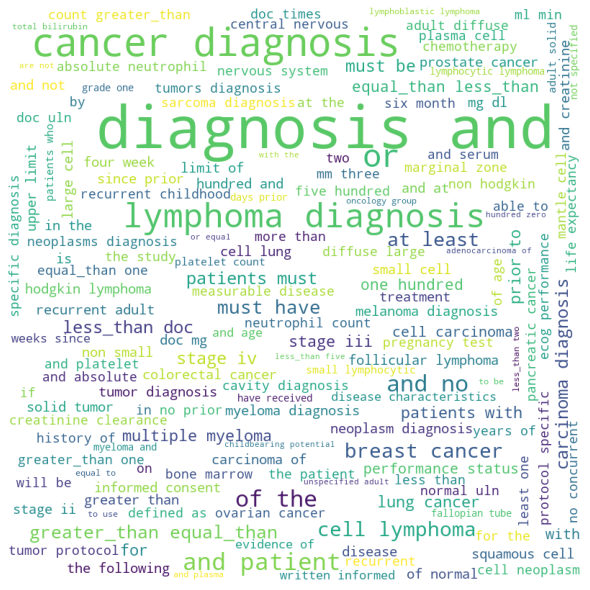

---------- Words for class: 1 ----------


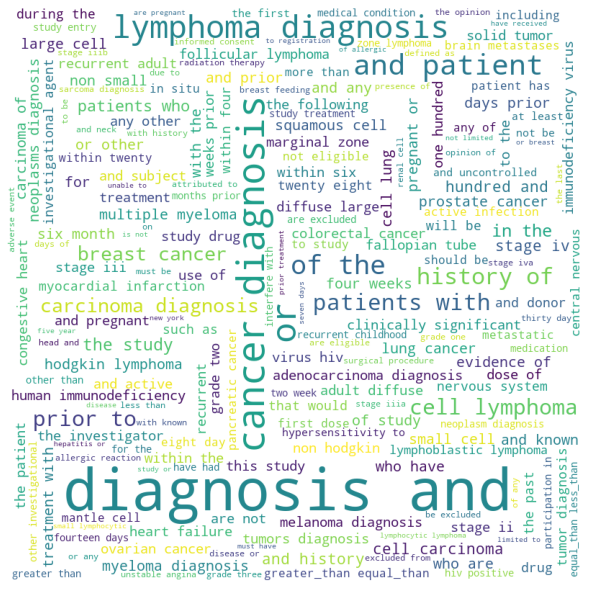

In [ ]:
for i in range(2):
    print(f'---------- Words for class: {i} ----------')
    mostrar_grafico( data.loc[data['label']==i,'condition'])

---------- Words for class: 0 ----------


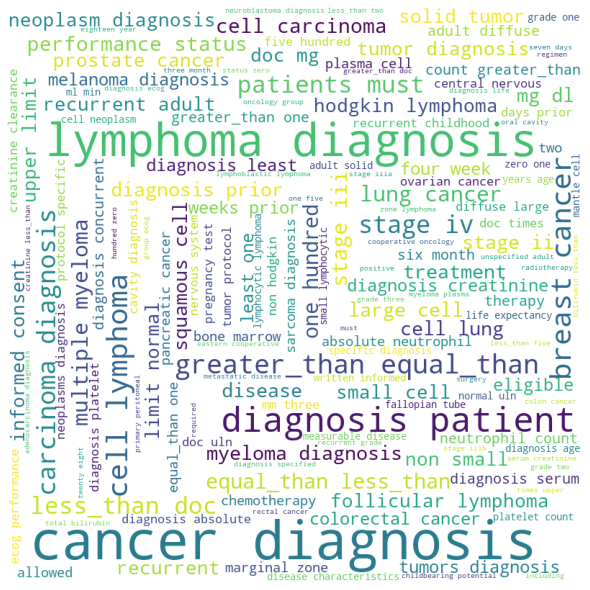

---------- Words for class: 1 ----------


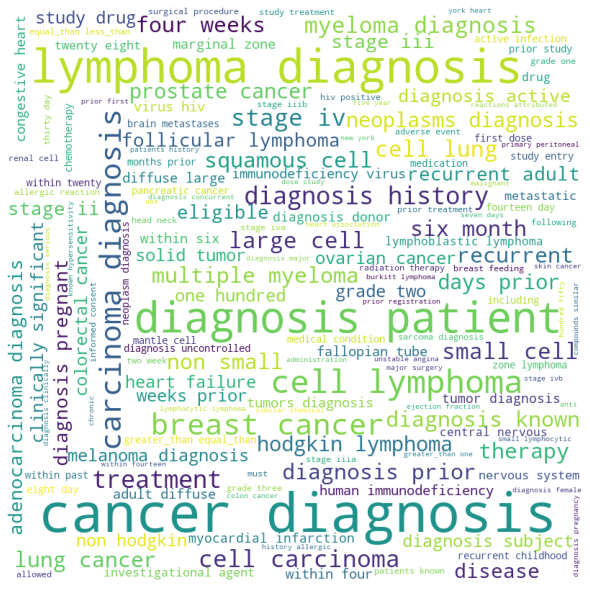

In [ ]:
for i in range(2):
    print(f'---------- Words for class: {i} ----------')
    mostrar_grafico( data.loc[data['label']==i,'condition'],stopwords=STOPWORDS)

Podemos ver que las palabras que más se repiten en ambos conjuntos son muy similares entre sí

# 3.Preparación de los datos
Autor: Juan Manuel Rivera

Se preparán las funciones para procesar los textos, y se dividirá la base de datos en train y test

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
X_train, y_train = train['condition'], train['label']
X_test, y_test = test['condition'], test['label']
X_train

288       stage ii pancreatic cancer diagnosis and crea...
2622      recurrent grade three follicular lymphoma dia...
6455      stage iii adult hodgkin lymphoma diagnosis an...
3673      extensive stage small cell lung cancer diagno...
7950                            lymphoma diagnosis and age
                               ...                        
11976     contiguous stage ii adult immunoblastic large...
5194      breast cancer diagnosis and repeated core nee...
5393              metastatic prostate cancer diagnosis and
860       stage iv squamous cell carcinoma of the paran...
7273      lung cancer diagnosis and absolute neutrophil...
Name: condition, Length: 9590, dtype: object

## 3.1 Eliminación del ruido
En esta fase se busca normalizar las palabras, de forma que dos palabras que tengan pequeñas diferencias entre sí no se consideren como distintas

### Expandir contracciones

Dado que las frases están en inglés, lo primero que se hará es expandir las contracciones, para que por ejemplo no tome that's y that is como dos palabras distintas

In [ ]:
new_X_train= X_train.apply(contractions.fix) #Aplica la corrección de las contracciones
new_X_train

288       stage ii pancreatic cancer diagnosis and crea...
2622      recurrent grade three follicular lymphoma dia...
6455      stage iii adult hodgkin lymphoma diagnosis an...
3673      extensive stage small cell lung cancer diagno...
7950                            lymphoma diagnosis and age
                               ...                        
11976     contiguous stage ii adult immunoblastic large...
5194      breast cancer diagnosis and repeated core nee...
5393              metastatic prostate cancer diagnosis and
860       stage iv squamous cell carcinoma of the paran...
7273      lung cancer diagnosis and absolute neutrophil...
Name: condition, Length: 9590, dtype: object

### Llevar todo a minúsculas

Para evitar que tome dos palabras iguales como diferentes se llevará a minúscula todas las letras

In [ ]:
def to_lowercase(phrase):
    new_phrase = []
    for word in phrase:
        new_word = word.lower()
        new_phrase.append(new_word)
    return "".join(new_phrase)

In [ ]:
new_X_train=new_X_train.apply(to_lowercase)
new_X_train

288       stage ii pancreatic cancer diagnosis and crea...
2622      recurrent grade three follicular lymphoma dia...
6455      stage iii adult hodgkin lymphoma diagnosis an...
3673      extensive stage small cell lung cancer diagno...
7950                            lymphoma diagnosis and age
                               ...                        
11976     contiguous stage ii adult immunoblastic large...
5194      breast cancer diagnosis and repeated core nee...
5393              metastatic prostate cancer diagnosis and
860       stage iv squamous cell carcinoma of the paran...
7273      lung cancer diagnosis and absolute neutrophil...
Name: condition, Length: 9590, dtype: object

### Extraer información de la etapa

Al ser contexto de pacientes oncológicos, la etapa en que se encuentra el cáncer es un factor importante. Por esto, se unirá la palabra stage con la siguiente palabra cuando esta sea un número romano

In [ ]:
etapasCancer= {"stage 0":"stage0","stage i":"stage1", "stage ii":"stage2", "stage iii":"stage3", "stage iv":"stage4"}

In [ ]:
def get_stages(phrase):
    words=phrase.split(" ")
    new_phrase = []
    prev_word=False

    for word in words:
      
      # Caso donde la palabra anterior es "stage"
      if prev_word:
        stage = "stage"+" "+word
        etapa=etapasCancer.get(stage)
        if etapa != None:
          # Si efectivamente es una etapa, añado esto a la palabra
          new_phrase.append(etapa+" ")
        prev_word=False
      else:
        if word != "stage":
          new_phrase.append(word)
          new_phrase.append(" ")
        else:
          prev_word=True
    return "".join(new_phrase)[:-1]

In [ ]:
new_X_train=new_X_train.apply(get_stages)
new_X_train

288       stage2 pancreatic cancer diagnosis and creati...
2622      recurrent grade three follicular lymphoma dia...
6455      stage3 adult hodgkin lymphoma diagnosis and s...
3673      extensive cell lung cancer diagnosis and reco...
7950                            lymphoma diagnosis and age
                               ...                        
11976     contiguous stage2 adult immunoblastic large c...
5194      breast cancer diagnosis and repeated core nee...
5393              metastatic prostate cancer diagnosis and
860       stage4 squamous cell carcinoma of the paranas...
7273      lung cancer diagnosis and absolute neutrophil...
Name: condition, Length: 9590, dtype: object

### Eliminar signos de puntuación

In [ ]:
def remove_punctuation(phrase):
    return phrase.translate(str.maketrans('','',string.punctuation))

In [ ]:
new_X_train=new_X_train.apply(remove_punctuation)
new_X_train

288       stage2 pancreatic cancer diagnosis and creati...
2622      recurrent grade three follicular lymphoma dia...
6455      stage3 adult hodgkin lymphoma diagnosis and s...
3673      extensive cell lung cancer diagnosis and reco...
7950                            lymphoma diagnosis and age
                               ...                        
11976     contiguous stage2 adult immunoblastic large c...
5194      breast cancer diagnosis and repeated core nee...
5393              metastatic prostate cancer diagnosis and
860       stage4 squamous cell carcinoma of the paranas...
7273      lung cancer diagnosis and absolute neutrophil...
Name: condition, Length: 9590, dtype: object

### Eliminar stopwords
Se retirarán conectores lógicos de las frases

In [ ]:
def remove_stopwords(phrase, stopwords=stopwords.words('english')):
    words=phrase.split(" ")
    new_phrase = []
    for word in words:
        if word not in stopwords:
            new_phrase.append(word)
            new_phrase.append(" ")
    return "".join(new_phrase)[:-1]

In [ ]:
new_X_train=new_X_train.apply(remove_stopwords)
new_X_train

288       stage2 pancreatic cancer diagnosis creatinine...
2622      recurrent grade three follicular lymphoma dia...
6455      stage3 adult hodgkin lymphoma diagnosis subje...
3673      extensive cell lung cancer diagnosis recovere...
7950                                lymphoma diagnosis age
                               ...                        
11976     contiguous stage2 adult immunoblastic large c...
5194      breast cancer diagnosis repeated core needle ...
5393                  metastatic prostate cancer diagnosis
860       stage4 squamous cell carcinoma paranasal sinu...
7273      lung cancer diagnosis absolute neutrophil cou...
Name: condition, Length: 9590, dtype: object

## 3.2 Tokenización
En esta fase se dividen las frases en palabras, donde cada palabra será un token

In [ ]:
new_X_train = new_X_train.apply(word_tokenize)
new_X_train.head()

288     [stage2, pancreatic, cancer, diagnosis, creati...
2622    [recurrent, grade, three, follicular, lymphoma...
6455    [stage3, adult, hodgkin, lymphoma, diagnosis, ...
3673    [extensive, cell, lung, cancer, diagnosis, rec...
7950                           [lymphoma, diagnosis, age]
Name: condition, dtype: object

## 3.3 Normalización

In [ ]:
# Funciones tomadas de https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    words = lemmatize_verbs(words)
    words = stem_words(words)
    return words

In [ ]:
new_X_train = new_X_train.apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
new_X_train.head()

288     [stage2, pancr, cant, diagnos, creatinin, gre,...
2622    [recur, grad, three, follicul, lymphom, diagno...
6455    [stage3, adult, hodgkin, lymphom, diagnos, sub...
3673    [extend, cel, lung, cant, diagnos, recov, pri,...
7950                               [lymphom, diagnos, ag]
Name: condition, dtype: object

In [ ]:
# Se guardan los textos procesados en la variable X_trian
new_X_train = new_X_train.apply(lambda x: ' '.join(map(str, x)))
new_X_train.head

<bound method NDFrame.head of 288      stage2 pancr cant diagnos creatinin gre doc mg dl
2622     recur grad three follicul lymphom diagnos pri ...
6455     stage3 adult hodgkin lymphom diagnos subject r...
3673        extend cel lung cant diagnos recov pri therapy
7950                                    lymphom diagnos ag
                               ...                        
11976    contigu stage2 adult immunoblast larg cel lymp...
5194       breast cant diagnos rep cor needl biopsy permit
5393                             metast prost cant diagnos
860      stage4 squam cel carcinom paranas sin nas cav ...
7273     lung cant diagnos absolv neutrophil count ant ...
Name: condition, Length: 9590, dtype: object>

Podemos ver el proceso de transformación tomando la siguiente frase como ejemplo

In [ ]:
X_train[228]

' kidney cancer diagnosis and more than twelve weeks'

In [ ]:
new_X_train[228]

'kidney cant diagnos twelv week'

## 3.4 Transformación en matriz de frecuencias
Se mirará la aparición de palabras dentro de cada texto. Para esto se tienen varias opciones: ver si la palabra está o no en el texto (tranformación binaria), ver el número de ocurrencias en cada frase (tranformación por frecuencia) o usando la transofrmación inversa de la frecuencia, donde se analiza la aparición de una palabra en un texto vs que tan frecuente es en todos los textos

In [ ]:
# Se transforma el texto con una transformación binaria 1 a 1.
dummy = CountVectorizer(binary=True, lowercase = False)
X_dummy = dummy.fit_transform(new_X_train)
print(X_dummy.shape)

(9590, 4641)


In [ ]:
# También, se puede realizar el conteo de las palabras presentes.
count = CountVectorizer()
X_count = count.fit_transform(new_X_train)
print(X_count.shape)

(9590, 4641)


In [ ]:
#Se puede realizar la transformación Term-frecuency times inverse Document-frecuency.
tf_idf = TfidfVectorizer()
X_tf_idf = tf_idf.fit_transform(new_X_train)
print(X_tf_idf.shape)

(9590, 4641)


# 4.Modelado

In [ ]:
#@title Definición de funciones para hacer el preprocesamiento. Recibe como input una columna con info del tratamiento del paciente
# {display-mode: "form"}

class TextPreprocessing(BaseEstimator,TransformerMixin):
  def __init__(self,stopwords=stopwords.words('english')):
    self.stopwords = stopwords
    
  def fit(self,X,y=None):
    return self

  def to_lowercase(phrase):
    new_phrase = []
    for word in phrase:
        new_word = word.lower()
        new_phrase.append(new_word)
    return "".join(new_phrase)
  
  etapasCancer= {"stage 0":"stage0",
                 "stage i":"stage1",
                 "stage ii":"stage2",
                 "stage iii":"stage3",
                 "stage iv":"stage4"}
  def get_stages(phrase):
    words=phrase.split(" ")
    new_phrase = []
    prev_word=False

    for word in words:
      
      # Caso donde la palabra anterior es "stage"
      if prev_word:
        stage = "stage"+" "+word
        etapa=etapasCancer.get(stage)
        if etapa != None:
          # Si efectivamente es una etapa, añado esto a la palabra
          new_phrase.append(etapa+" ")
        prev_word=False
      else:
        if word != "stage":
          new_phrase.append(word)
          new_phrase.append(" ")
        else:
          prev_word=True
    return "".join(new_phrase)[:-1]

  def remove_punctuation(phrase):
    return phrase.translate(str.maketrans('','',string.punctuation))

  def remove_stopwords(phrase, stopwords=stopwords.words('english')):
    words=phrase.split(" ")
    new_phrase = []
    for word in words:
        if word not in stopwords:
            new_phrase.append(word)
            new_phrase.append(" ")
    return "".join(new_phrase)[:-1]

  def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

  def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

  def stem_and_lemmatize(words):
    words = lemmatize_verbs(words)
    words = stem_words(words)
    return words

    
  def transform(self,X,y=None):
    new_X_train = X.apply(contractions.fix) #Aplica la corrección de las contracciones
    new_X_train=new_X_train.apply(to_lowercase)
    new_X_train=new_X_train.apply(get_stages)
    new_X_train=new_X_train.apply(remove_punctuation)
    new_X_train=new_X_train.apply(remove_stopwords)
    new_X_train = new_X_train.apply(word_tokenize)
    new_X_train = new_X_train.apply(stem_and_lemmatize)
    new_X_train = new_X_train.apply(lambda x: ' '.join(map(str, x)))
    return new_X_train

## Árbol de decisión
Autor: Juan Manuel Rivera

In [ ]:
# Dado que el preprocesamiento ya se realizó para los datos de X_train, se correrá el pipeline sin la parte del preproceso
estimators = [
        #('preproccess',TextPreprocessing()),
        ('transform',CountVectorizer(lowercase=False)),
        ('classifier', DecisionTreeClassifier(random_state=0))          
    ]

parameters = {'transform':[CountVectorizer(binary=True,lowercase=False),
                           CountVectorizer(lowercase=False),
                           TfidfVectorizer(lowercase=False),
                           CountVectorizer(binary=True,lowercase=False, min_df=0.01, max_df=0.95),
                           CountVectorizer(lowercase=False, min_df=0.01, max_df=0.96),
                           TfidfVectorizer(lowercase=False, min_df=0.01, max_df=0.96),],
              'classifier__criterion':['gini','entropy'],
              'classifier__max_depth':[2,4,8,16,24,28,32,36,40],
              'classifier__min_samples_split':[2,3],
            }

pipe_tree = Pipeline(estimators)


In [ ]:
%%time
grid_search_tree = GridSearchCV(pipe_tree, parameters, scoring='f1', cv=4, error_score=0.0)
grid_search_tree.fit(new_X_train,y_train)

CPU times: user 3min 59s, sys: 678 ms, total: 4min
Wall time: 4min 6s


In [ ]:
grid_search_tree.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 40,
 'classifier__min_samples_split': 3,
 'transform': TfidfVectorizer(lowercase=False)}

In [ ]:
y_pred_train_tree = grid_search_tree.best_estimator_.predict(X_train)
report_tree = classification_report(y_train, y_pred_train_tree)

print("Train Report\n", report_tree)

Train Report
               precision    recall  f1-score   support

           0       0.77      0.34      0.47      4791
           1       0.58      0.90      0.70      4799

    accuracy                           0.62      9590
   macro avg       0.67      0.62      0.59      9590
weighted avg       0.67      0.62      0.59      9590



In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=y_train, y_pred=y_pred_train_tree, classes=["0 - Elegible","1 - No elegible"],
                      title='Matriz de Confusión - train')

NameError: ignored

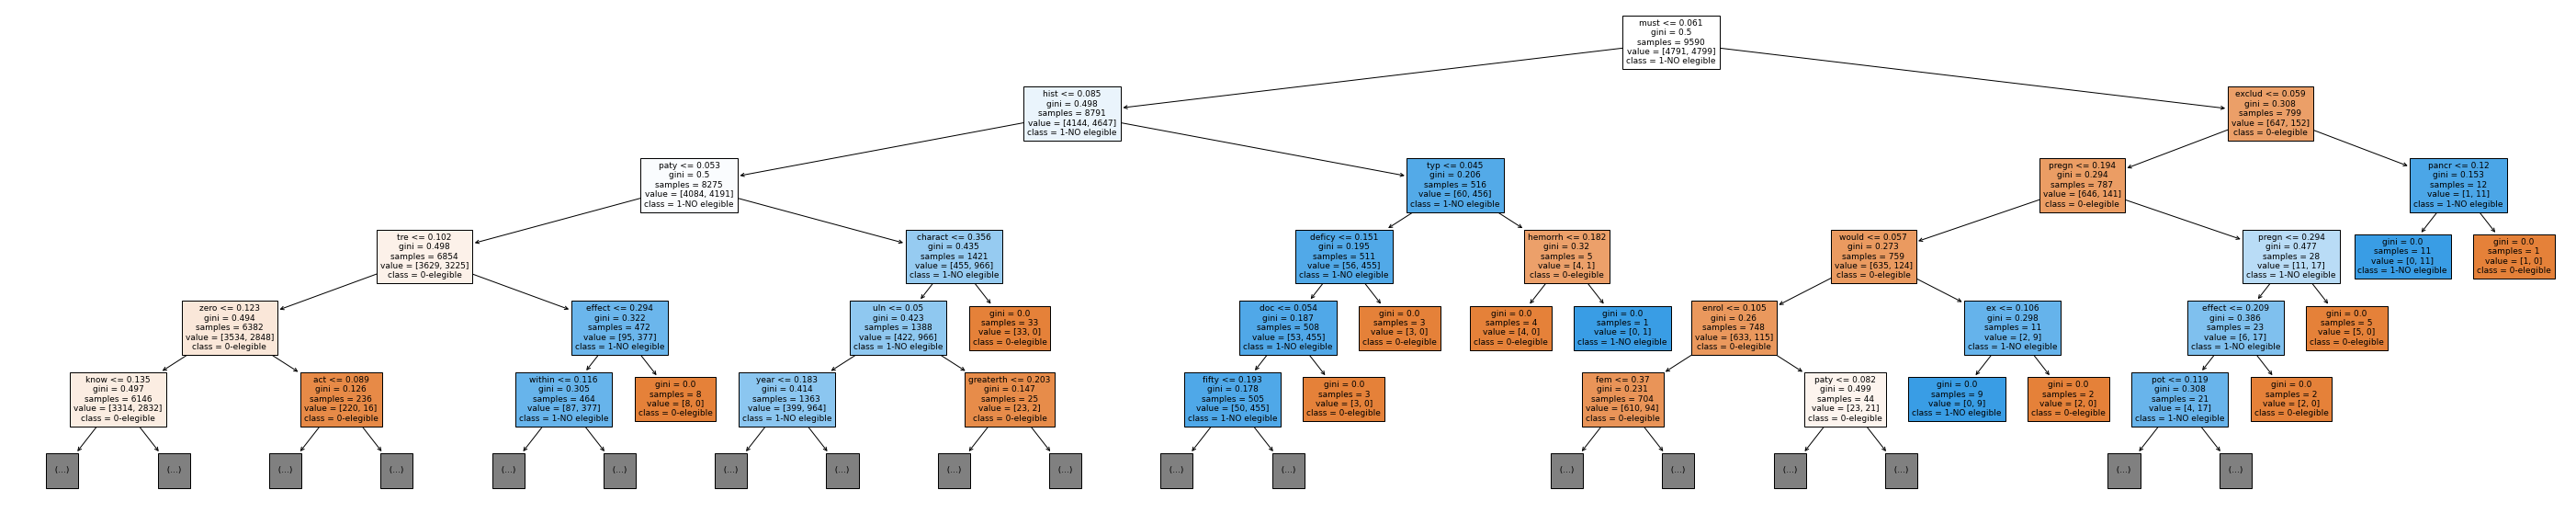

In [ ]:
best_tree=grid_search_tree.best_estimator_['classifier']
fig = plt.figure(figsize=(50,10))
_ = tree.plot_tree(best_tree, max_depth=5, feature_names=grid_search_tree.best_estimator_['transform'].get_feature_names_out(), class_names=["0-elegible", "1-NO elegible"], filled=True, fontsize=9)

In [ ]:
# Ahora se usará un pipeline con el mejor modelo para analizar los datos de test
estimators = [
        ('preproccess',TextPreprocessing()),
        ('transform',TfidfVectorizer(lowercase=False)),
        ('classifier', DecisionTreeClassifier(criterion='gini',max_depth=40, min_samples_split=3,random_state=0))]

pipe_tree_test = Pipeline(estimators)

In [ ]:
pipe_tree_test.fit(X_train, y_train)

Pipeline(steps=[('preproccess', TextPreprocessing()),
                ('transform', TfidfVectorizer(lowercase=False)),
                ('classifier',
                 DecisionTreeClassifier(max_depth=40, min_samples_split=3,
                                        random_state=0))])

In [ ]:
y_test_tree=pipe_tree_test.predict(X_test)

In [ ]:
print("Tree Accuracy Score (test) -> ",accuracy_score(y_test_tree, y_test)*100)

Tree Accuracy Score (test) ->  72.6021684737281


In [ ]:
report_tree_test = classification_report(y_test, y_test_tree)

print("Tree test Report\n", report_tree_test)

Tree test Report
               precision    recall  f1-score   support

           0       0.73      0.71      0.72      1201
           1       0.72      0.74      0.73      1197

    accuracy                           0.73      2398
   macro avg       0.73      0.73      0.73      2398
weighted avg       0.73      0.73      0.73      2398



In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=y_test, y_pred=y_test_tree, classes=["0 - Elegible","1 - No elegible"],
                      title='Matriz de Confusión - test')

NameError: ignored

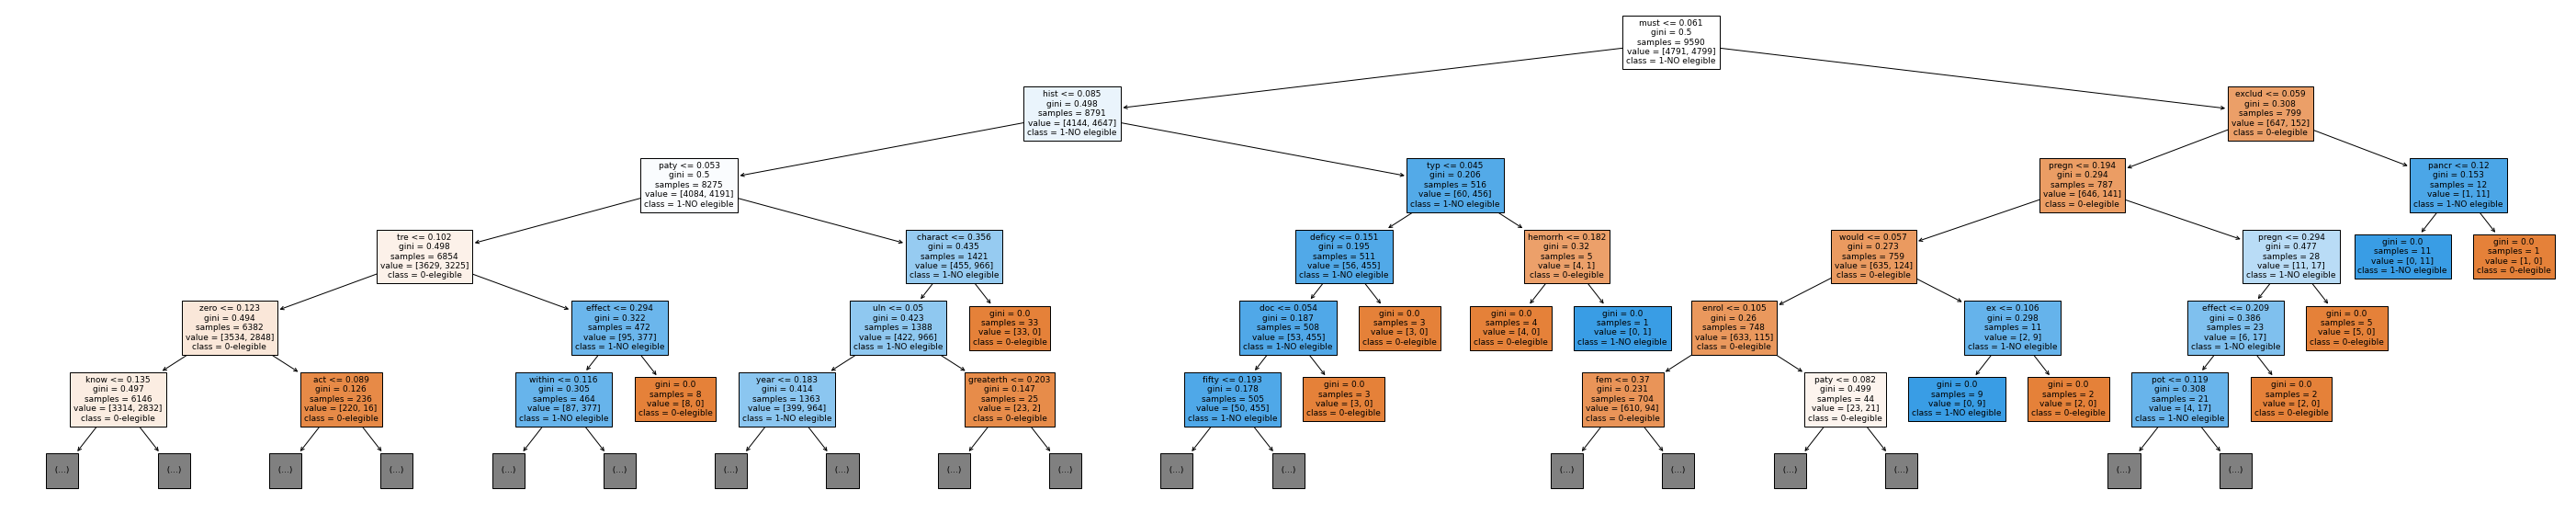

In [ ]:
fig = plt.figure(figsize=(50,10))
_ = tree.plot_tree(pipe_tree_test['classifier'], max_depth=5, feature_names=grid_search_tree.best_estimator_['transform'].get_feature_names_out(), class_names=["0-elegible", "1-NO elegible"], filled=True, fontsize=9)

## KNN

Autor: Juan David Villamil Rodriguez

A continuacion se define un pipeline que se encargara de procesar los datos de entrada y de usar el clasificador knn sobre los datos

In [ ]:
# Dado que el preprocesamiento ya se realizó para los datos de X_train, estos no requeieren del preprocesamiento
estimators = [
        ('transform',CountVectorizer(lowercase=False)),
        ('classifier', KNeighborsClassifier())          
    ]

parameters = {'transform':[CountVectorizer(binary=True,lowercase=False),
                           CountVectorizer(lowercase=False),
                           TfidfVectorizer(lowercase=False),
                           CountVectorizer(binary=True,lowercase=False, min_df=0.01, max_df=0.95),
                           CountVectorizer(lowercase=False, min_df=0.01, max_df=0.96),
                           TfidfVectorizer(lowercase=False, min_df=0.01, max_df=0.96),],
              'classifier__weights':['distance'],
              'classifier__n_neighbors':[6,7,8,9,10,11,12],
              'classifier__p':[1,2],
            }

pipe_knn = Pipeline(estimators)

Busqueda de los mejores valores para los hiperparametros n_neighbors y p de el algoritmo knn

In [ ]:
%%time
grid_search_knn = GridSearchCV(pipe_knn, parameters, scoring='f1', cv=4, error_score=0.0)
grid_search_knn.fit(new_X_train,y_train)

CPU times: user 9min 48s, sys: 1.93 s, total: 9min 49s
Wall time: 6min 24s


In [ ]:
grid_search_knn.best_params_

{'classifier__n_neighbors': 6,
 'classifier__p': 2,
 'classifier__weights': 'distance',
 'transform': TfidfVectorizer(lowercase=False)}

In [ ]:
 #Los valores de los mejores hyperparametros
print('Best p:', grid_search_knn.best_estimator_.get_params()['classifier__p'])
print('Best n_neighbors:', grid_search_knn.best_estimator_.get_params()['classifier__n_neighbors'])

Best p: 2
Best n_neighbors: 6


In [ ]:
# Obtener el mejor modelo.
mejor_knn = grid_search_knn.best_estimator_

y_pred_train_knn = mejor_knn.predict(X_train)

report_tree = classification_report(y_train, y_pred_train_knn)

print("Train Report\n", report_tree)

Train Report
               precision    recall  f1-score   support

           0       0.67      0.77      0.71      4791
           1       0.73      0.61      0.67      4799

    accuracy                           0.69      9590
   macro avg       0.70      0.69      0.69      9590
weighted avg       0.70      0.69      0.69      9590



In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=y_train, y_pred=y_pred_train_knn, classes=["0 - Elegible","1 - No elegible"],
                      title='Matriz de Confusión - train')

NameError: ignored

In [ ]:
# Ahora se usará un pipeline con el mejor modelo para analizar los datos de test
estimators = [
        ('preproccess',TextPreprocessing()),
        ('transform',TfidfVectorizer(lowercase=False)),
        ('classifier', KNeighborsClassifier(p=2,n_neighbors=6,weights='distance'))]

pipe_knn_test = Pipeline(estimators)

In [ ]:
%%time
pipe_knn_test.fit(X_train, y_train)

CPU times: user 5.03 s, sys: 39 ms, total: 5.06 s
Wall time: 5.07 s


Pipeline(steps=[('preproccess', TextPreprocessing()),
                ('transform', TfidfVectorizer(lowercase=False)),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=6, weights='distance'))])

In [ ]:
# y_pred_test_knn = mejor_knn.predict(X_test)
y_pred_test_knn=pipe_knn_test.predict(X_test)

report_tree = classification_report(y_test, y_pred_test_knn)

print("KNN Test Report\n", report_tree)

KNN Test Report
               precision    recall  f1-score   support

           0       0.75      0.80      0.77      1201
           1       0.78      0.73      0.76      1197

    accuracy                           0.77      2398
   macro avg       0.77      0.77      0.77      2398
weighted avg       0.77      0.77      0.77      2398



In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=y_test, y_pred=y_pred_test_knn, classes=["0 - Elegible","1 - No elegible"],
                      title='Matriz de Confusión - test')

NameError: ignored

## SVM
Autor: Juan Sebastián Arévalo Moreno

Primero transformamos nuestros datos asignando a cada palabra un entero, esto luego lo convertiremos en los vectores para pasarselos al modelo. Como las variables Train_X_Tfidf y Test_X_Tfidf para luego probarlo.

In [ ]:
# Dado que el preprocesamiento ya se realizó para los datos de X_train, se correrá el pipeline sin la parte del preproceso
estimators = [
        #('preproccess',TextPreprocessing()),
        ('transform',CountVectorizer(lowercase=False)),
        ('classifier', svm.SVC(C=0.1, kernel='linear', gamma='auto'))          
    ]

parameters = {'transform':[CountVectorizer(binary=True,lowercase=False),
                           CountVectorizer(lowercase=False),
                           TfidfVectorizer(lowercase=False),
                           CountVectorizer(binary=True,lowercase=False, min_df=0.01, max_df=0.95),
                           CountVectorizer(lowercase=False, min_df=0.01, max_df=0.96),
                           TfidfVectorizer(lowercase=False, min_df=0.01, max_df=0.96),],
              'classifier__C':[0.1, 1, 10],
              'classifier__gamma':['scale', 'auto'],
              'classifier__kernel':['linear','rbf'],
            }

pipe_svm = Pipeline(estimators)

In [ ]:
%%time
grid_search_svm = GridSearchCV(pipe_svm, parameters, scoring='f1', cv=3, verbose = 3)
with tf.device('/device:GPU:0'):
  grid_search_svm.fit(new_X_train,y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END classifier__C=0.1, classifier__gamma=scale, classifier__kernel=linear, transform=CountVectorizer(binary=True, lowercase=False);, score=0.768 total time=   4.4s
[CV 2/3] END classifier__C=0.1, classifier__gamma=scale, classifier__kernel=linear, transform=CountVectorizer(binary=True, lowercase=False);, score=0.802 total time=   4.5s
[CV 3/3] END classifier__C=0.1, classifier__gamma=scale, classifier__kernel=linear, transform=CountVectorizer(binary=True, lowercase=False);, score=0.797 total time=   4.6s
[CV 1/3] END classifier__C=0.1, classifier__gamma=scale, classifier__kernel=linear, transform=CountVectorizer(lowercase=False);, score=0.766 total time=   4.4s
[CV 2/3] END classifier__C=0.1, classifier__gamma=scale, classifier__kernel=linear, transform=CountVectorizer(lowercase=False);, score=0.798 total time=   4.5s
[CV 3/3] END classifier__C=0.1, classifier__gamma=scale, classifier__kernel=linear, transform=Count

In [ ]:
grid_search_svm.best_params_

In [ ]:
# Obtener el mejor modelo.
mejor_svm = grid_search_svm.best_estimator_

y_pred_train_svm = mejor_svm.predict(X_train)

report_svm = classification_report(y_train, y_pred_train_svm)

print("Train Report\n", report_svm)

In [ ]:
%matplotlib inline
plot_confusion_matrix(y_true=y_train, y_pred=y_pred_train_svm, classes=["0 - Elegible","1 - No elegible"],
                      title='Matriz de Confusión - train')

In [ ]:
# Ahora se usará un pipeline con el mejor modelo para analizar los datos de test
estimators = [
        ('preproccess',TextPreprocessing()),
        ('transform',TfidfVectorizer(lowercase=False)),
        ('classifier', svm.SVC( C=1,gamma="scale", kernel="rbf" ))]

pipe_svm_test = Pipeline(estimators)

In [ ]:
%%time
pipe_svm_test.fit(X_train, y_train)

In [117]:
y_pred_test_svm=pipe_svm_test.predict(X_test)

report_tree = classification_report(y_test, y_pred_test_svm)

print("SVM Test Report\n", report_tree)

SVM Test Report
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      1201
           1       0.82      0.83      0.82      1197

    accuracy                           0.82      2398
   macro avg       0.82      0.82      0.82      2398
weighted avg       0.82      0.82      0.82      2398



Confusion matrix, without normalization


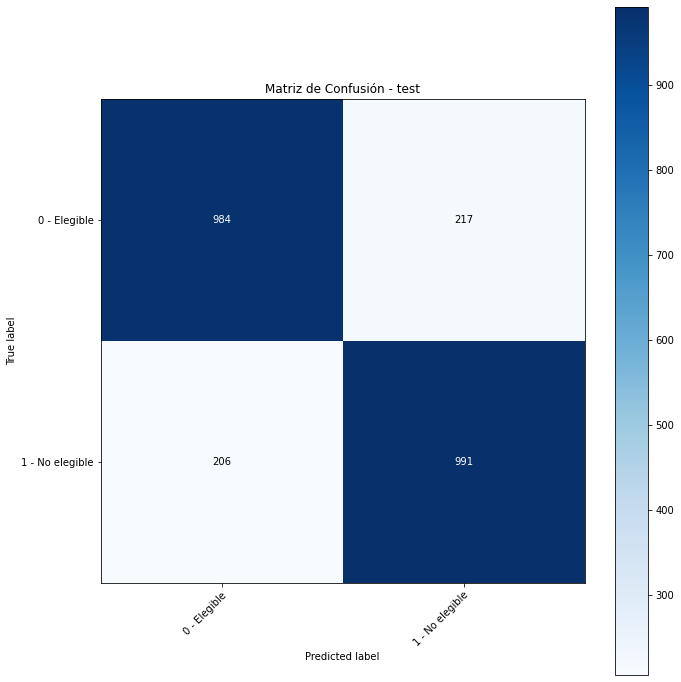

In [118]:
%matplotlib inline
plot_confusion_matrix(y_true=y_test, y_pred=y_pred_test_svm, classes=["0 - Elegible","1 - No elegible"],
                      title='Matriz de Confusión - test')

In [ ]:
%%time
TP=TextPreprocessing()
new_X_test=TP.transform(X_test)
new_condition=TP.transform(data['condition'])

In [ ]:
Tfidf_vect = TfidfVectorizer()
#Tfidf_vect.fit(data['condition'])
Tfidf_vect.fit(new_condition)

In [ ]:
Train_X_Tfidf = Tfidf_vect.transform(new_X_train)
Test_X_Tfidf = Tfidf_vect.transform(new_X_test)

Aca podemos observar como a cada palabra se le asigno su respectivo entero.

In [ ]:
print(Tfidf_vect.vocabulary_)


Ahora corremos una primera versión del modelo con unos hiperparametros genericos con un C=0.01 y un gamma automatico con un kernel lineal.

In [ ]:
SVM = svm.SVC(C=0.1, kernel='linear', gamma='auto')
SVM.fit(Train_X_Tfidf,y_train)


In [ ]:
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

A continuación efectuamos un GridSearch para ver si podemos mejorar nuestro accuracy, esto lo haremos iterando con valores de C entre 0.1, 1 y 10 y valores de Gamma: de 1, 0.01 y 0.0001.

In [ ]:
%%time
# defining parameter range
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.01, 0.0001],
              'kernel': ['linear']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(Train_X_Tfidf,y_train)

Vemos que los mejores hiperparametros son C=1 y Gamma=1.

In [ ]:
print(grid.best_params_)

print(grid.best_estimator_)

In [ ]:
grid_predictions = grid.predict(Test_X_Tfidf)
 
print("SVM Accuracy Score -> ",accuracy_score(grid_predictions, y_test)*100)

In [ ]:
grid_predictions = grid.predict(Train_X_Tfidf)
 
print("SVM Accuracy Score -> ",accuracy_score(grid_predictions, y_train)*100)

In [ ]:
SVMOptimo = svm.SVC(C=1, kernel='linear', gamma=1)
SVMOptimo.fit(Train_X_Tfidf,y_train)
# Get support vector indices
support_vector_indices = SVMOptimo.support_
print(support_vector_indices)

In [ ]:
# Get number of support vectors per class
support_vectors_per_class = SVMOptimo.n_support_
print(support_vectors_per_class)

In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [ ]:
Train_X_Tfidf

In [ ]:
print(Tfidf_vect.vocabulary_)


# 5.Exportar el mejor modelo

Al analizar el desempeño de los modelos usando el indicador f1, podemos ver que los modelos tuvieron los siguientes resultados al evaluarlo contra el conjunto de test:

| Modelo      | f1 score |
| ----------- | ----------- |
| Árbol de decisión     | 0,73       |
| KNN                   | 0,77       |
| SVM                   | 0,82       |

Por esto, decidimos exportar el modelo de la máquina de soporte vectorial.

Antes de exprotar el modelo, se realizará una prueba con una cadena de texto similar a la que se esperaría recibir en la aplicación.

In [ ]:
def procesarTextoEntrante(input):
  temp={0:input}
  dataInput=pd.DataFrame.from_dict(temp, orient='index',
                       columns=['condition'])
  column=dataInput['condition']
  return column

In [ ]:
X_test[0]

In [ ]:
procesarTextoEntrante(X_test[0])

In [ ]:
pipe_svm_test.predict(procesarTextoEntrante(X_test[0]))

El pipeline espera recibir una columna de un dataframe. Por esto, la función procesarTextoEntrante se usará para pasar un texto a columna

In [ ]:
# Usamos la lbreria joblib
filename = 'best_model.joblib'
# Se guarda
dump(pipe_svm_test, filename) 